In [ ]:
!pip install --quiet prophet

In [ ]:
import pandas as pd
from prophet import Prophet
from tqdm import tqdm
import numpy as np
import os

In [ ]:
# Step 1: Mount Google Drive (optional for saving results)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ✅ Prophet Forecast for All CPZ Stations (Daily, Improved)


# Step 2: Load Already Merged Yearly File
data_path = "/content/cpz_station_timeseries_2024_yearly_15min.csv"
df = pd.read_csv(data_path, parse_dates=["time_bucket"])
df.dropna(subset=["time_bucket"], inplace=True)
df['start_station_id'] = df['start_station_id'].astype(str)
print(f"✅ Loaded yearly data with shape: {df.shape}")

# Step 3: Resample to Daily Booking Counts
df_daily = df.set_index("time_bucket")
df_daily = df_daily.groupby("start_station_id").resample("D")["booking_count"].sum().reset_index()

# Step 4: Forecast Per Station Using Prophet (with log transform + cap)
forecast_horizon = 90  # days into future
output_dir = "/content/drive/MyDrive/citibike_project/forecast_output_2024"
os.makedirs(output_dir, exist_ok=True)

unique_stations = df_daily['start_station_id'].unique()
print(f"🔁 Running forecasts for {len(unique_stations)} stations...")

for station_id in tqdm(unique_stations):
    station_df = df_daily[df_daily['start_station_id'] == station_id][['time_bucket', 'booking_count']]
    station_df = station_df.rename(columns={"time_bucket": "ds", "booking_count": "y"})

    # Skip stations with insufficient data
    if len(station_df) < 30:
        continue

    try:
        # Replace 0s and log-transform
        station_df['y'] = station_df['y'].apply(lambda x: max(x, 0.1))
        station_df['y'] = np.log(station_df['y'])

        # Set cap for logistic growth
        station_df['cap'] = station_df['y'].max() * 1.2

        model = Prophet(growth='logistic')
        model.fit(station_df)

        future = model.make_future_dataframe(periods=forecast_horizon)
        future['cap'] = station_df['cap'].iloc[0]

        forecast = model.predict(future)

        # Reverse log transform
        forecast['yhat'] = np.exp(forecast['yhat'])
        forecast['yhat_lower'] = np.exp(forecast['yhat_lower'])
        forecast['yhat_upper'] = np.exp(forecast['yhat_upper'])

        forecast_out = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        forecast_out['start_station_id'] = station_id

        # Save forecast
        output_file = f"{output_dir}/forecast_station_{station_id.replace(' ', '_')}.csv"
        forecast_out.to_csv(output_file, index=False)

    except Exception as e:
        print(f"❌ Error with station {station_id}: {e}")

print("✅ Forecasting complete! All files saved to:", output_dir)

<ipython-input-13-6e06df22f7f0>:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, parse_dates=["time_bucket"])


✅ Loaded yearly data with shape: (15524343, 3)
🔁 Running forecasts for 2136 stations...


  0%|          | 0/2136 [00:00<?, ?it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/oa5xiwws.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/18goceqd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99055', 'data', 'file=/tmp/tmp23x7_fip/oa5xiwws.json', 'init=/tmp/tmp23x7_fip/18goceqd.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model081kwth1/prophet_model-20250325164758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:47:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:47:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


❌ Error with station 2832.03: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
  0%|          | 7/2136 [00:01<09:32,  3.72it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/4caejv7n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/10ir736d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5485', 'data', 'file=/tmp/tmp23x7_fip/4caejv7n.json'

❌ Error with station 2883.03: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
  0%|          | 10/2136 [00:02<09:14,  3.83it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/669epdt1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/26yedazv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64100', 'data', 'file=/tmp/tmp23x7_fip/669epdt1.jso

❌ Error with station 3138.09: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
  2%|▏         | 41/2136 [00:16<11:11,  3.12it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/v85iggu_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/k_ythih8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76028', 'data', 'file=/tmp/tmp23x7_fip/v85iggu_.jso

❌ Error with station 3178.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
  2%|▏         | 52/2136 [00:20<11:02,  3.15it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/qsjp67tj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/lv70guoe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32777', 'data', 'file=/tmp/tmp23x7_fip/qsjp67tj.jso

❌ Error with station 3373.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
  5%|▍         | 104/2136 [00:44<15:28,  2.19it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/lkbjts7p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/0njz2rlc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86179', 'data', 'file=/tmp/tmp23x7_fip/lkbjts7p.js

❌ Error with station 3742.11: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
  9%|▉         | 194/2136 [01:24<11:40,  2.77it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/m8gyg8i_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/gjnl1m4r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39860', 'data', 'file=/tmp/tmp23x7_fip/m8gyg8i_.js

❌ Error with station 3814.01: cap must be greater than floor (which defaults to 0).


16:49:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 10%|▉         | 208/2136 [01:32<16:54,  1.90it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/n3pzvm94.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/qhfnz6a_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/

❌ Error with station 3845.05: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 10%|█         | 214/2136 [01:34<11:57,  2.68it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/msa3ztur.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ngooucp4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96085', 'data', 'file=/tmp/tmp23x7_fip/msa3ztur.js

❌ Error with station 3853.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 10%|█         | 217/2136 [01:35<10:24,  3.08it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/bv670vsr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/hwprvu42.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5742', 'data', 'file=/tmp/tmp23x7_fip/bv670vsr.jso

❌ Error with station 3877.04: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 10%|█         | 223/2136 [01:37<10:13,  3.12it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/rpjqecyv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/dblt_7oz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26865', 'data', 'file=/tmp/tmp23x7_fip/rpjqecyv.js

❌ Error with station 3958.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 12%|█▏        | 248/2136 [01:49<15:29,  2.03it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/tkx8l1j0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/mytjbxhi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33356', 'data', 'file=/tmp/tmp23x7_fip/tkx8l1j0.js

❌ Error with station 4031.05: cap must be greater than floor (which defaults to 0).


16:49:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 13%|█▎        | 275/2136 [02:00<13:46,  2.25it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/bw06oev1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/6dcd9wt5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/

❌ Error with station 4039.04: cap must be greater than floor (which defaults to 0).


16:50:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 13%|█▎        | 278/2136 [02:01<13:14,  2.34it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/8yvybdqn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/etqe7qvr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/

❌ Error with station 4055.04: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 13%|█▎        | 284/2136 [02:04<14:35,  2.12it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/3zmphh8v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/6c7esvcw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22803', 'data', 'file=/tmp/tmp23x7_fip/3zmphh8v.js

❌ Error with station 4064.03: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 13%|█▎        | 287/2136 [02:06<12:49,  2.40it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/phjja2si.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/xit4qjwp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35087', 'data', 'file=/tmp/tmp23x7_fip/phjja2si.js

❌ Error with station 4087.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 14%|█▍        | 296/2136 [02:09<10:35,  2.90it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/qgly8m_s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ozvul8h5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16400', 'data', 'file=/tmp/tmp23x7_fip/qgly8m_s.js

❌ Error with station 4113.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 14%|█▍        | 307/2136 [02:13<09:46,  3.12it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/44xzu731.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/4jueyvzk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12865', 'data', 'file=/tmp/tmp23x7_fip/44xzu731.js

❌ Error with station 4138.04: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 15%|█▍        | 320/2136 [02:21<14:45,  2.05it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/s61dwk45.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/qc15n2jl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15100', 'data', 'file=/tmp/tmp23x7_fip/s61dwk45.js

❌ Error with station 4161.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 15%|█▌        | 329/2136 [02:25<10:49,  2.78it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/enjugpv0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/aynkf_lf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75684', 'data', 'file=/tmp/tmp23x7_fip/enjugpv0.js

❌ Error with station 4187.04: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 16%|█▌        | 340/2136 [02:30<10:44,  2.79it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/zk442djb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/7_v9738t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33118', 'data', 'file=/tmp/tmp23x7_fip/zk442djb.js

❌ Error with station 4212.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 16%|█▋        | 351/2136 [02:35<12:44,  2.34it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ha8aq_i8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/62o6ejc8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5488', 'data', 'file=/tmp/tmp23x7_fip/ha8aq_i8.jso

❌ Error with station 4220.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 17%|█▋        | 356/2136 [02:37<14:15,  2.08it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/l0zwamu0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/5_ug9gtk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84186', 'data', 'file=/tmp/tmp23x7_fip/l0zwamu0.js

❌ Error with station 4244.06: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 17%|█▋        | 365/2136 [02:41<10:31,  2.80it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/aah34e3c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/qpw6klu4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26492', 'data', 'file=/tmp/tmp23x7_fip/aah34e3c.js

❌ Error with station 4253.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 17%|█▋        | 369/2136 [02:42<10:29,  2.81it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/5oa5m5ef.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/2w4m_nh4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43318', 'data', 'file=/tmp/tmp23x7_fip/5oa5m5ef.js

❌ Error with station 4261.03: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 17%|█▋        | 372/2136 [02:43<09:43,  3.02it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/5yacc76y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/9lg6n_w3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95104', 'data', 'file=/tmp/tmp23x7_fip/5yacc76y.js

❌ Error with station 4285.09: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 18%|█▊        | 377/2136 [02:45<09:52,  2.97it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/h80x7gq6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/esxy6m_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5473', 'data', 'file=/tmp/tmp23x7_fip/h80x7gq6.jso

❌ Error with station 4293.05: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 18%|█▊        | 379/2136 [02:46<08:59,  3.26it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/36wwbbkj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/o3v3ir5n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27095', 'data', 'file=/tmp/tmp23x7_fip/36wwbbkj.js

❌ Error with station 4301.07: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 18%|█▊        | 382/2136 [02:47<08:22,  3.49it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/4s068jpd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/5zogq_gt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58079', 'data', 'file=/tmp/tmp23x7_fip/4s068jpd.js

❌ Error with station 4334.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 18%|█▊        | 391/2136 [02:51<12:51,  2.26it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ob_8_vei.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/os8zodxk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47827', 'data', 'file=/tmp/tmp23x7_fip/ob_8_vei.js

❌ Error with station 4357.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 19%|█▉        | 401/2136 [02:55<09:36,  3.01it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ogftr4tl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/f99sgd3x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19468', 'data', 'file=/tmp/tmp23x7_fip/ogftr4tl.js

❌ Error with station 4366.01: cap must be greater than floor (which defaults to 0).
❌ Error with station 4366.1: cap must be greater than floor (which defaults to 0).


16:50:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 19%|█▉        | 402/2136 [02:56<11:02,  2.62it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/df81sq8y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/dkz0tgwk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/

❌ Error with station 4432.1: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 20%|█▉        | 425/2136 [03:08<13:42,  2.08it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/0i4ub624.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/py4zlbfn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34824', 'data', 'file=/tmp/tmp23x7_fip/0i4ub624.js

❌ Error with station 4474.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 21%|██        | 445/2136 [03:17<10:14,  2.75it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/avbjm0_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ocamqedf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93154', 'data', 'file=/tmp/tmp23x7_fip/avbjm0_a.js

❌ Error with station 4550.05: cap must be greater than floor (which defaults to 0).


16:51:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 22%|██▏       | 473/2136 [03:30<12:15,  2.26it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/gmhq7_km.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/rfpeobpp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/

❌ Error with station 4568.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 22%|██▏       | 478/2136 [03:34<17:00,  1.62it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/a2du7m30.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/lxco1kj2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57659', 'data', 'file=/tmp/tmp23x7_fip/a2du7m30.js

❌ Error with station 4591.04: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 23%|██▎       | 483/2136 [03:36<10:33,  2.61it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/d9n5mlzy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/hd9lvw4c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19301', 'data', 'file=/tmp/tmp23x7_fip/d9n5mlzy.js

❌ Error with station 4672.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 24%|██▍       | 515/2136 [03:51<09:52,  2.74it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/lw7un2c0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/psoepf4z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90036', 'data', 'file=/tmp/tmp23x7_fip/lw7un2c0.js

❌ Error with station 4680.05: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 24%|██▍       | 518/2136 [03:52<09:03,  2.98it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/bzfmm33x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/em9wrfij.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10734', 'data', 'file=/tmp/tmp23x7_fip/bzfmm33x.js

❌ Error with station 4721.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 25%|██▌       | 534/2136 [03:59<09:28,  2.82it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/0ei7kd30.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/1b3w0i1_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74075', 'data', 'file=/tmp/tmp23x7_fip/0ei7kd30.js

❌ Error with station 4727.06: cap must be greater than floor (which defaults to 0).


16:51:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 25%|██▌       | 536/2136 [03:59<09:41,  2.75it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/4umm2w8q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/v_7pye07.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/

❌ Error with station 4743.04: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 25%|██▌       | 542/2136 [04:02<10:42,  2.48it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/cve627wa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/j4t_lmp3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43521', 'data', 'file=/tmp/tmp23x7_fip/cve627wa.js

❌ Error with station 4757.06: cap must be greater than floor (which defaults to 0).


16:52:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 26%|██▌       | 546/2136 [04:04<11:51,  2.24it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/3sds1k4f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/c4zowwrx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/

❌ Error with station 4798.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 26%|██▋       | 561/2136 [04:10<07:43,  3.40it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/7sr5u4yx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/qrz0_81n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84044', 'data', 'file=/tmp/tmp23x7_fip/7sr5u4yx.js

❌ Error with station 4816.02: cap must be greater than floor (which defaults to 0).
❌ Error with station 4816.05: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 27%|██▋       | 568/2136 [04:13<07:48,  3.35it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/xrur9ag8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/m7hxyte1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74548', 'data', 'file=/tmp/tmp23x7_fip/xrur9ag8.js

❌ Error with station 4830.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 27%|██▋       | 577/2136 [04:16<09:21,  2.78it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/7fj__yx3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/qnux04ve.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87210', 'data', 'file=/tmp/tmp23x7_fip/7fj__yx3.js

❌ Error with station 4862.07: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 28%|██▊       | 589/2136 [04:22<10:25,  2.47it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/jl3yv786.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/yo62h8c1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66955', 'data', 'file=/tmp/tmp23x7_fip/jl3yv786.js

❌ Error with station 4880.11: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 28%|██▊       | 593/2136 [04:24<11:03,  2.33it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/7cdfjab5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/bxqovsim.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37317', 'data', 'file=/tmp/tmp23x7_fip/7cdfjab5.js

❌ Error with station 4890.11: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 28%|██▊       | 596/2136 [04:25<10:03,  2.55it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/rgc1hunq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/xgrp58dz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95904', 'data', 'file=/tmp/tmp23x7_fip/rgc1hunq.js

❌ Error with station 4898.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 28%|██▊       | 601/2136 [04:27<09:30,  2.69it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/troe48ls.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/84oo67lt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17953', 'data', 'file=/tmp/tmp23x7_fip/troe48ls.js

❌ Error with station 4921.04: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 29%|██▊       | 609/2136 [04:30<08:20,  3.05it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/6l0byqzu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/b96muh5f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82001', 'data', 'file=/tmp/tmp23x7_fip/6l0byqzu.js

❌ Error with station 4945.06: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 29%|██▉       | 617/2136 [04:33<09:11,  2.75it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/i4oknsny.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/svuw17hy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89588', 'data', 'file=/tmp/tmp23x7_fip/i4oknsny.js

❌ Error with station 4971.01: cap must be greater than floor (which defaults to 0).
❌ Error with station 4977.03: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/envdhni3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/uax9bzr_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58794', 'data', 'file=/tmp/tmp23x7_fip/envdhni3.json', 'init=/tmp/tmp23x7_fip/uax9bzr_.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelcrx5g2_y/prophet_model-20250325165237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:52:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:52:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

❌ Error with station 4985.09: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 30%|██▉       | 633/2136 [04:40<09:25,  2.66it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/25adgro8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ugtbtfe_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30128', 'data', 'file=/tmp/tmp23x7_fip/25adgro8.js

❌ Error with station 5025.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 30%|███       | 648/2136 [04:47<09:06,  2.72it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/gbi6grzs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/p1epb9z_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23878', 'data', 'file=/tmp/tmp23x7_fip/gbi6grzs.js

❌ Error with station 5090.06: cap must be greater than floor (which defaults to 0).


16:52:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 31%|███▏      | 672/2136 [04:58<11:02,  2.21it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/0f3k6vo1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/axoiy3j1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/

❌ Error with station 5097.02: cap must be greater than floor (which defaults to 0).


16:52:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 32%|███▏      | 675/2136 [04:59<10:22,  2.35it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/dqd6kyp3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/t1ea4udp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/

❌ Error with station 5129.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 32%|███▏      | 691/2136 [05:07<09:21,  2.57it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/tdat6r1v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/s35kzfrc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92594', 'data', 'file=/tmp/tmp23x7_fip/tdat6r1v.js

❌ Error with station 5138.03: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 33%|███▎      | 696/2136 [05:09<08:41,  2.76it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ao2w5xct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/cvlk5hct.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22545', 'data', 'file=/tmp/tmp23x7_fip/ao2w5xct.js

❌ Error with station 5160.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 33%|███▎      | 704/2136 [05:13<09:06,  2.62it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/waxvf56z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/khordrf_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86611', 'data', 'file=/tmp/tmp23x7_fip/waxvf56z.js

❌ Error with station 5168.04: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 33%|███▎      | 707/2136 [05:14<08:49,  2.70it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ldf36jgd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/49ouorpy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89140', 'data', 'file=/tmp/tmp23x7_fip/ldf36jgd.js

❌ Error with station 5176.04: cap must be greater than floor (which defaults to 0).


16:53:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 33%|███▎      | 710/2136 [05:15<10:05,  2.35it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/5sa4_b97.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/u7zw8wxd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/

❌ Error with station 5199.01: cap must be greater than floor (which defaults to 0).


16:53:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 34%|███▎      | 719/2136 [05:23<18:58,  1.24it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/tp1t95tb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ou7iwpx_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/

❌ Error with station 5217.03: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/u74sl4yo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50148', 'data', 'file=/tmp/tmp23x7_fip/06udkqik.json', 'init=/tmp/tmp23x7_fip/u74sl4yo.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelhwku437x/prophet_model-20250325165326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:53:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:53:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

❌ Error with station 5225.09: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 34%|███▍      | 730/2136 [05:29<08:45,  2.67it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/obc4pfka.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/rsrpcvyk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77961', 'data', 'file=/tmp/tmp23x7_fip/obc4pfka.js

❌ Error with station 5257.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 35%|███▍      | 739/2136 [05:33<07:59,  2.92it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/2ujowzaq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/0q7y0rci.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2620', 'data', 'file=/tmp/tmp23x7_fip/2ujowzaq.jso

❌ Error with station 5280.03: cap must be greater than floor (which defaults to 0).


16:53:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 35%|███▌      | 751/2136 [05:38<10:41,  2.16it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/1qtnvu_h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/bcmdu6t3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/

❌ Error with station 5289.05: cap must be greater than floor (which defaults to 0).


16:53:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 35%|███▌      | 756/2136 [05:41<11:08,  2.06it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/t01u9ats.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/a2ckp16i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/

❌ Error with station 5360.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 37%|███▋      | 785/2136 [05:56<10:18,  2.18it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/8q0h7770.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/3jqcwrr4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64739', 'data', 'file=/tmp/tmp23x7_fip/8q0h7770.js

❌ Error with station 5392.04: cap must be greater than floor (which defaults to 0).


16:54:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 37%|███▋      | 798/2136 [06:04<12:31,  1.78it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/t9ijm11c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/xbyp6fvt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/

❌ Error with station 5401.03: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 37%|███▋      | 800/2136 [06:04<10:16,  2.17it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/u1ijkw2_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/q4w0vfr8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77853', 'data', 'file=/tmp/tmp23x7_fip/u1ijkw2_.js

❌ Error with station 5409.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 38%|███▊      | 805/2136 [06:06<08:46,  2.53it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/wi2i9jvq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/9qbah53h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77760', 'data', 'file=/tmp/tmp23x7_fip/wi2i9jvq.js

❌ Error with station 5440.05: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 38%|███▊      | 819/2136 [06:13<08:44,  2.51it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/hsgpua3s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/v86wyp4z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47924', 'data', 'file=/tmp/tmp23x7_fip/hsgpua3s.js

❌ Error with station 5548.01: cap must be greater than floor (which defaults to 0).


16:54:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 40%|████      | 860/2136 [06:36<10:30,  2.02it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/89en2ek3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/fbd_4xdx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/

❌ Error with station 5570.04: cap must be greater than floor (which defaults to 0).


16:54:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 41%|████      | 871/2136 [06:43<11:33,  1.82it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/yyzx7om_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/e9d3alog.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/

❌ Error with station 5579.02: cap must be greater than floor (which defaults to 0).
❌ Error with station 5579.04: cap must be greater than floor (which defaults to 0).


16:54:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 41%|████      | 877/2136 [06:45<07:50,  2.67it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/jpwg1x5j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/chkxnqwu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/

❌ Error with station 5688.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 43%|████▎     | 913/2136 [07:05<09:42,  2.10it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/so_5q1zd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/r708kdyw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13914', 'data', 'file=/tmp/tmp23x7_fip/so_5q1zd.js

❌ Error with station 5806.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 45%|████▍     | 955/2136 [07:28<08:39,  2.27it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/zrv9e8ai.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/krpggkkp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55413', 'data', 'file=/tmp/tmp23x7_fip/zrv9e8ai.js

❌ Error with station 5845.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 45%|████▍     | 960/2136 [07:30<07:49,  2.51it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/176t284n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/8ouc9gj9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76808', 'data', 'file=/tmp/tmp23x7_fip/176t284n.js

❌ Error with station 5878.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 46%|████▌     | 973/2136 [07:38<10:08,  1.91it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/8xnkdfgb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/uiehnjgs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90298', 'data', 'file=/tmp/tmp23x7_fip/8xnkdfgb.js

❌ Error with station 5887.03: cap must be greater than floor (which defaults to 0).


16:55:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 46%|████▌     | 978/2136 [07:40<10:03,  1.92it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ptsvmrme.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/v9d3ptoj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/

❌ Error with station 5923.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 46%|████▋     | 990/2136 [07:46<07:43,  2.47it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/2kxrsw4a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/6yno649o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24800', 'data', 'file=/tmp/tmp23x7_fip/2kxrsw4a.js

❌ Error with station 5930.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 46%|████▋     | 992/2136 [07:47<06:57,  2.74it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/o_cg5c51.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/799sgziv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15614', 'data', 'file=/tmp/tmp23x7_fip/o_cg5c51.js

❌ Error with station 5956.04: cap must be greater than floor (which defaults to 0).
❌ Error with station 5956.05: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/2qc54d7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29208', 'data', 'file=/tmp/tmp23x7_fip/ota_c52m.json', 'init=/tmp/tmp23x7_fip/2qc54d7i.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelsx9wxn8b/prophet_model-20250325165549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:55:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:55:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

❌ Error with station 5998.09: cap must be greater than floor (which defaults to 0).


16:55:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 48%|████▊     | 1016/2136 [07:58<09:35,  1.95it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/npcsxf0t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ehqilbh9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 6016.06: cap must be greater than floor (which defaults to 0).


16:55:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 48%|████▊     | 1023/2136 [08:00<07:39,  2.42it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/khavq3us.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/uhj8mhtl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 6025.08: cap must be greater than floor (which defaults to 0).
❌ Error with station 6028.01: cap must be greater than floor (which defaults to 0).


16:56:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 48%|████▊     | 1027/2136 [08:02<06:54,  2.68it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/mg3b7lv4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/sr7x9fgv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 6058.08: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 49%|████▊     | 1036/2136 [08:06<06:16,  2.92it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/r9zfqchg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ncuyc4st.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56930', 'data', 'file=/tmp/tmp23x7_fip/r9zfqchg.j

❌ Error with station 6090.03: cap must be greater than floor (which defaults to 0).
❌ Error with station 6092.01: cap must be greater than floor (which defaults to 0).


16:56:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 49%|████▉     | 1049/2136 [08:11<06:39,  2.72it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/v13umsih.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/uerjxngu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 6099.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 49%|████▉     | 1054/2136 [08:13<07:01,  2.57it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/f7l7h37m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/9gzujq2b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13445', 'data', 'file=/tmp/tmp23x7_fip/f7l7h37m.j

❌ Error with station 6108.03: cap must be greater than floor (which defaults to 0).


16:56:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 50%|████▉     | 1058/2136 [08:16<09:18,  1.93it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/zkv4p0u3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/o897l0j7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 6116.03: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 50%|████▉     | 1063/2136 [08:18<08:29,  2.11it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/y01r0udq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/53accwfi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57543', 'data', 'file=/tmp/tmp23x7_fip/y01r0udq.j

❌ Error with station 6134.03: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 50%|█████     | 1072/2136 [08:22<07:25,  2.39it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/p6rtkk4a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/9i9rqjcl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85777', 'data', 'file=/tmp/tmp23x7_fip/p6rtkk4a.j

❌ Error with station 6141.02: cap must be greater than floor (which defaults to 0).
❌ Error with station 6143.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 50%|█████     | 1078/2136 [08:24<05:26,  3.24it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/tlxj4qne.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/kb7q49jb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33704', 'data', 'file=/tmp/tmp23x7_fip/tlxj4qne.j

❌ Error with station 6149.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 51%|█████     | 1081/2136 [08:26<06:28,  2.71it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/m4kzwwet.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/hq8hnjpv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11998', 'data', 'file=/tmp/tmp23x7_fip/m4kzwwet.j

❌ Error with station 6158.02: cap must be greater than floor (which defaults to 0).
❌ Error with station 6158.06: cap must be greater than floor (which defaults to 0).


16:56:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 51%|█████     | 1085/2136 [08:27<06:05,  2.88it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/4wjsmyzw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/5h3gp_5d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 6176.11: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 51%|█████     | 1094/2136 [08:30<04:56,  3.51it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/u4qkncdi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/afeagt0y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63305', 'data', 'file=/tmp/tmp23x7_fip/u4qkncdi.j

❌ Error with station 6200.03: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 52%|█████▏    | 1106/2136 [08:36<08:35,  2.00it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/55cdg96a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/lmketagt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91218', 'data', 'file=/tmp/tmp23x7_fip/55cdg96a.j

❌ Error with station 6218.04: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/locb3exf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43416', 'data', 'file=/tmp/tmp23x7_fip/pin0pc9z.json', 'init=/tmp/tmp23x7_fip/locb3exf.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model9ggtxva2/prophet_model-20250325165640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:56:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:56:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

❌ Error with station 6225.03: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 53%|█████▎    | 1122/2136 [08:44<06:29,  2.60it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/jfxaj3_k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/c0j5swir.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59424', 'data', 'file=/tmp/tmp23x7_fip/jfxaj3_k.j

❌ Error with station 6234.04: cap must be greater than floor (which defaults to 0).


16:56:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 53%|█████▎    | 1129/2136 [08:47<06:46,  2.48it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/i5s5mtg1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/_knvfpf7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 6249.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 53%|█████▎    | 1140/2136 [08:51<05:19,  3.12it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ldu9ov8y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/nxc2f26m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42019', 'data', 'file=/tmp/tmp23x7_fip/ldu9ov8y.j

❌ Error with station 6258.02: cap must be greater than floor (which defaults to 0).
❌ Error with station 6258.03: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/wv3cg2ls.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/59h4blyb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53509', 'data', 'file=/tmp/tmp23x7_fip/wv3cg2ls.json', 'init=/tmp/tmp23x7_fip/59h4blyb.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelkbasjsp9/prophet_model-20250325165652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:56:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:56:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

❌ Error with station 6276.02: cap must be greater than floor (which defaults to 0).
❌ Error with station 6276.05: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/06e0gsjz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/2j2_ifly.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3630', 'data', 'file=/tmp/tmp23x7_fip/06e0gsjz.json', 'init=/tmp/tmp23x7_fip/2j2_ifly.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model6q3il_kp/prophet_model-20250325165653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:56:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:56:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

❌ Error with station 6290.06: cap must be greater than floor (which defaults to 0).
❌ Error with station 6290.13: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/swm2kq4l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/gjw5fjtm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64075', 'data', 'file=/tmp/tmp23x7_fip/swm2kq4l.json', 'init=/tmp/tmp23x7_fip/gjw5fjtm.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model84czzmpd/prophet_model-20250325165657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:56:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:56:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

❌ Error with station 6298.04: cap must be greater than floor (which defaults to 0).


16:56:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 55%|█████▍    | 1165/2136 [09:01<07:43,  2.09it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/u4c6ssir.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/g95zvrnf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 6307.07: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 55%|█████▍    | 1172/2136 [09:05<07:48,  2.06it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/dtme6rhj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ii83qh1d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99753', 'data', 'file=/tmp/tmp23x7_fip/dtme6rhj.j

❌ Error with station 6325.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 55%|█████▌    | 1185/2136 [09:11<06:11,  2.56it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/vcccix3r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/_5h4kyvl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36561', 'data', 'file=/tmp/tmp23x7_fip/vcccix3r.j

❌ Error with station 6332.06: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 56%|█████▌    | 1187/2136 [09:11<05:34,  2.84it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/n814zrry.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/9b01c3yr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84650', 'data', 'file=/tmp/tmp23x7_fip/n814zrry.j

❌ Error with station 6334.03: cap must be greater than floor (which defaults to 0).


16:57:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 56%|█████▌    | 1190/2136 [09:12<04:43,  3.33it/s]

❌ Error with station 6340.09: cap must be greater than floor (which defaults to 0).
❌ Error with station 6346.07: cap must be greater than floor (which defaults to 0).


 56%|█████▌    | 1193/2136 [09:13<03:11,  4.92it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ume5_a8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/uhrta_d4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56617', 'data', 'file=/tmp/tmp23x7_fip/ume5_a8h.json', 'init=/tmp/tmp23x7_fip/uhrta_d4.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model0ddkrd37/prophet_model-20250325165711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:57:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:57:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done 

❌ Error with station 6356.01: cap must be greater than floor (which defaults to 0).
❌ Error with station 6358.05: cap must be greater than floor (which defaults to 0).


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/r3bwxwvl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/shox82q6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43768', 'data', 'file=/tmp/tmp23x7_fip/r3bwxwvl.json', 'init=/tmp/tmp23x7_fip/shox82q6.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelmsj_xnuu/prophet_model-20250325165712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:57:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:57:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: Sett

❌ Error with station 6383.06: cap must be greater than floor (which defaults to 0).


16:57:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 57%|█████▋    | 1208/2136 [09:19<07:03,  2.19it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ysn_pd51.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/nye4s0mb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 6399.06: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 57%|█████▋    | 1215/2136 [09:22<05:13,  2.93it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/834fs8ln.json


❌ Error with station 6408.08: cap must be greater than floor (which defaults to 0).
❌ Error with station 6414.07: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/fbpxiyrl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3612', 'data', 'file=/tmp/tmp23x7_fip/834fs8ln.json', 'init=/tmp/tmp23x7_fip/fbpxiyrl.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelt8d24jy5/prophet_model-20250325165721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:57:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:57:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

❌ Error with station 6426.05: cap must be greater than floor (which defaults to 0).


16:57:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 57%|█████▋    | 1226/2136 [09:25<04:18,  3.51it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/yypxkkq_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/u85flc0_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 6435.02: cap must be greater than floor (which defaults to 0).
❌ Error with station 6435.03: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 58%|█████▊    | 1232/2136 [09:28<05:13,  2.88it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/15zxigsr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/er0q_h62.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2331', 'data', 'file=/tmp/tmp23x7_fip/15zxigsr.js

❌ Error with station 6468.01: cap must be greater than floor (which defaults to 0).


16:57:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 59%|█████▊    | 1252/2136 [09:37<06:35,  2.23it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/iiduhuo2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/mn4tv43n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 6475.07: cap must be greater than floor (which defaults to 0).


16:57:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 59%|█████▉    | 1257/2136 [09:39<05:00,  2.93it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


❌ Error with station 6486.07: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/_i_8__of.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/3z2a8c27.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58281', 'data', 'file=/tmp/tmp23x7_fip/_i_8__of.json', 'init=/tmp/tmp23x7_fip/3z2a8c27.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelscem6xh4/prophet_model-20250325165738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:57:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:57:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

❌ Error with station 6493.03: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 59%|█████▉    | 1261/2136 [09:41<06:06,  2.39it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/q6ixmh9k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/5gcgr0ij.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8288', 'data', 'file=/tmp/tmp23x7_fip/q6ixmh9k.js

❌ Error with station 6502.01: cap must be greater than floor (which defaults to 0).


INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 59%|█████▉    | 1268/2136 [09:44<04:08,  3.50it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/cnp84jeg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/3q1h97m8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72441', 

❌ Error with station 6511.03: cap must be greater than floor (which defaults to 0).


INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 59%|█████▉    | 1269/2136 [09:44<04:58,  2.90it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/c9fpefa_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/nwo7m6fn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57635', 

❌ Error with station 6515.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 60%|█████▉    | 1271/2136 [09:45<04:50,  2.98it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/b658cjrv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/g814h_8d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83406', 'data', 'file=/tmp/tmp23x7_fip/b658cjrv.j

❌ Error with station 6520.06: cap must be greater than floor (which defaults to 0).
❌ Error with station 6520.07: cap must be greater than floor (which defaults to 0).


 60%|█████▉    | 1276/2136 [09:46<02:41,  5.34it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/qk5piru_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/s6i72tv_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8944', 'data', 'file=/tmp/tmp23x7_fip/qk5piru_.json', 'init=/tmp/tmp23x7_fip/s6i72tv_.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model7aqvke7h/prophet_model-20250325165745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:57:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:57:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done p

❌ Error with station 6527.07: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 60%|█████▉    | 1280/2136 [09:47<04:23,  3.24it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/8yimfukw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/pnuj_yp0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8760', 'data', 'file=/tmp/tmp23x7_fip/8yimfukw.js

❌ Error with station 6536.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 60%|██████    | 1284/2136 [09:49<05:35,  2.54it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/0jbylolb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/1cs0h1a9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81595', 'data', 'file=/tmp/tmp23x7_fip/0jbylolb.j

❌ Error with station 6545.07: cap must be greater than floor (which defaults to 0).


16:57:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 60%|██████    | 1288/2136 [09:51<05:11,  2.72it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/v6m7fxj3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/k6jt1j75.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 6552.07: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 60%|██████    | 1291/2136 [09:52<05:29,  2.57it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/166zp3a8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/k_kfrilu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90403', 'data', 'file=/tmp/tmp23x7_fip/166zp3a8.j

❌ Error with station 6563.12: cap must be greater than floor (which defaults to 0).


16:57:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 61%|██████    | 1298/2136 [09:55<05:08,  2.72it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/2nif8evl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/oro3b48x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 6579.03: cap must be greater than floor (which defaults to 0).


16:57:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 61%|██████▏   | 1309/2136 [10:00<05:52,  2.35it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/03xgm9_k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/3o_838kd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 6587.04: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 61%|██████▏   | 1313/2136 [10:02<05:01,  2.73it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/v5udf5uv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/f3o7glm2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51039', 'data', 'file=/tmp/tmp23x7_fip/v5udf5uv.j

❌ Error with station 6603.06: cap must be greater than floor (which defaults to 0).


16:58:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 62%|██████▏   | 1322/2136 [10:05<05:28,  2.48it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ayk3jrv2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/4guo1_1c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 6612.09: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 62%|██████▏   | 1328/2136 [10:08<05:54,  2.28it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/pzicv0sm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ja87eun1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98372', 'data', 'file=/tmp/tmp23x7_fip/pzicv0sm.j

❌ Error with station 6621.06: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 62%|██████▏   | 1333/2136 [10:10<05:11,  2.58it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/_ejktoug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/6opzx60f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82293', 'data', 'file=/tmp/tmp23x7_fip/_ejktoug.j

❌ Error with station 6645.06: cap must be greater than floor (which defaults to 0).


16:58:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 63%|██████▎   | 1342/2136 [10:15<06:42,  1.97it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/yef62lkt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/sczh_s4p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 6662.09: cap must be greater than floor (which defaults to 0).


16:58:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 63%|██████▎   | 1353/2136 [10:24<10:45,  1.21it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/tzfad2yw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/sr7cs4ah.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 6679.11: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 64%|██████▎   | 1360/2136 [10:28<06:35,  1.96it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/uipxow8w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/cqxc_2c7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67071', 'data', 'file=/tmp/tmp23x7_fip/uipxow8w.j

❌ Error with station 6703.06: cap must be greater than floor (which defaults to 0).


16:58:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 64%|██████▍   | 1369/2136 [10:32<05:47,  2.21it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/pzavfmsq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/26hasi4s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 6718.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 64%|██████▍   | 1375/2136 [10:35<04:50,  2.62it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/eualuy39.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ys_143y8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77401', 'data', 'file=/tmp/tmp23x7_fip/eualuy39.j

❌ Error with station 6789.2: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 66%|██████▌   | 1413/2136 [10:53<05:14,  2.30it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/gnyg9zyi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/tiiq2xtn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35928', 'data', 'file=/tmp/tmp23x7_fip/gnyg9zyi.j

❌ Error with station 6825.03: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 67%|██████▋   | 1431/2136 [11:01<04:36,  2.55it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/zeg_7t2v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/lh8uj3w7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44308', 'data', 'file=/tmp/tmp23x7_fip/zeg_7t2v.j

❌ Error with station 6842.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 67%|██████▋   | 1440/2136 [11:05<04:19,  2.69it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/gb1nvvzz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/v_zgj1yq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30382', 'data', 'file=/tmp/tmp23x7_fip/gb1nvvzz.j

❌ Error with station 6877.05: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 68%|██████▊   | 1452/2136 [11:10<04:18,  2.64it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/2rk0nonu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/eit6_s14.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8501', 'data', 'file=/tmp/tmp23x7_fip/2rk0nonu.js

❌ Error with station 6923.2: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 69%|██████▉   | 1470/2136 [11:19<03:59,  2.79it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/m64lk71z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/lmz04ntf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36113', 'data', 'file=/tmp/tmp23x7_fip/m64lk71z.j

❌ Error with station 6929.01: cap must be greater than floor (which defaults to 0).


16:59:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 69%|██████▉   | 1475/2136 [11:21<04:02,  2.73it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/x2u1cf53.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/0660zxzk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 6935.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 69%|██████▉   | 1478/2136 [11:22<04:08,  2.65it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/7vz5vg6s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/uy9vczra.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73014', 'data', 'file=/tmp/tmp23x7_fip/7vz5vg6s.j

❌ Error with station 6960.1: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 70%|██████▉   | 1488/2136 [11:26<03:41,  2.92it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/2l5hji8j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/niwv8rva.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73433', 'data', 'file=/tmp/tmp23x7_fip/2l5hji8j.j

❌ Error with station 6964.05: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 70%|██████▉   | 1491/2136 [11:27<03:17,  3.27it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/neu546uc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/cmd0l1d9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58518', 'data', 'file=/tmp/tmp23x7_fip/neu546uc.j

❌ Error with station 6978.04: cap must be greater than floor (which defaults to 0).
❌ Error with station 6981.16: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/32zwtxc5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/0sz4a1qm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5271', 'data', 'file=/tmp/tmp23x7_fip/32zwtxc5.json', 'init=/tmp/tmp23x7_fip/0sz4a1qm.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model8qgyhyvw/prophet_model-20250325165927.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:59:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:59:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

❌ Error with station 6994.06: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 70%|███████   | 1499/2136 [11:30<03:40,  2.90it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/zs24tmwy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/91shs720.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77822', 'data', 'file=/tmp/tmp23x7_fip/zs24tmwy.j

❌ Error with station 7009.02: cap must be greater than floor (which defaults to 0).


16:59:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 70%|███████   | 1503/2136 [11:32<03:50,  2.74it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/9p1iup9z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/xa15y3v5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 7032.02: cap must be greater than floor (which defaults to 0).
❌ Error with station 7032.06: cap must be greater than floor (which defaults to 0).
❌ Error with station 7034.09: cap must be greater than floor (which defaults to 0).


 71%|███████   | 1514/2136 [11:36<02:30,  4.14it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


❌ Error with station 7039.03: cap must be greater than floor (which defaults to 0).
❌ Error with station 7047.07: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/5il3o7ei.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/tcze8bek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64713', 'data', 'file=/tmp/tmp23x7_fip/5il3o7ei.json', 'init=/tmp/tmp23x7_fip/tcze8bek.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model5583_sw2/prophet_model-20250325165935.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:59:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:59:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

❌ Error with station 7066.01: cap must be greater than floor (which defaults to 0).
❌ Error with station 7068.07: cap must be greater than floor (which defaults to 0).
❌ Error with station 7074.01: cap must be greater than floor (which defaults to 0).


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/e5j2rcs1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/tg3c6z7y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23260', 'data', 'file=/tmp/tmp23x7_fip/e5j2rcs1.json', 'init=/tmp/tmp23x7_fip/tg3c6z7y.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelirm0iylu/prophet_model-20250325165938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:59:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:59:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: Sett

❌ Error with station 7119.04: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 72%|███████▏  | 1537/2136 [11:44<03:07,  3.20it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/faiqtkb6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/384vexp1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81897', 'data', 'file=/tmp/tmp23x7_fip/faiqtkb6.j

❌ Error with station 7126.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 72%|███████▏  | 1543/2136 [11:45<02:04,  4.76it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/c9y5j2fa.json


❌ Error with station 7132.08: cap must be greater than floor (which defaults to 0).
❌ Error with station 7137.04: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/1krbf2ei.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19358', 'data', 'file=/tmp/tmp23x7_fip/c9y5j2fa.json', 'init=/tmp/tmp23x7_fip/1krbf2ei.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelesze2qrz/prophet_model-20250325165944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:59:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:59:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

❌ Error with station 7152.10: cap must be greater than floor (which defaults to 0).


16:59:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 73%|███████▎  | 1551/2136 [11:47<02:09,  4.52it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/bo4htmzz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/17_ljk5y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 7165.01: cap must be greater than floor (which defaults to 0).
❌ Error with station 7170.04: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ml_cx99f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8873', 'data', 'file=/tmp/tmp23x7_fip/p34bfvhr.json', 'init=/tmp/tmp23x7_fip/ml_cx99f.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelyjs15t1c/prophet_model-20250325165948.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:59:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:59:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

❌ Error with station 7178.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 73%|███████▎  | 1560/2136 [11:51<03:56,  2.43it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/0qfzmspj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/fm6apaft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34276', 'data', 'file=/tmp/tmp23x7_fip/0qfzmspj.j

❌ Error with station 7186.15: cap must be greater than floor (which defaults to 0).
❌ Error with station 7188.1: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/vm0zqdge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/w6q7e9d0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93174', 'data', 'file=/tmp/tmp23x7_fip/vm0zqdge.json', 'init=/tmp/tmp23x7_fip/w6q7e9d0.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model_nru90je/prophet_model-20250325165951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:59:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:59:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

❌ Error with station 7196.04: cap must be greater than floor (which defaults to 0).
❌ Error with station 7202.07: cap must be greater than floor (which defaults to 0).


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/4enoh_ni.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/u3is2vch.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68939', 'data', 'file=/tmp/tmp23x7_fip/4enoh_ni.json', 'init=/tmp/tmp23x7_fip/u3is2vch.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelrkkwhr51/prophet_model-20250325165952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:59:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:59:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

❌ Error with station 7210.07: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 74%|███████▎  | 1571/2136 [11:54<03:06,  3.03it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/1elt0ywb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/qlpzybzz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98730', 'data', 'file=/tmp/tmp23x7_fip/1elt0ywb.j

❌ Error with station 7233.05: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 74%|███████▍  | 1576/2136 [11:56<03:05,  3.02it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/733rh6nn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/x5cy4x6r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62726', 'data', 'file=/tmp/tmp23x7_fip/733rh6nn.j

❌ Error with station 7286.05: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 74%|███████▍  | 1591/2136 [12:01<02:07,  4.28it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/zj956_bo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/bicngqkv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74815', 'data', 'file=/tmp/tmp23x7_fip/zj956_bo.j

❌ Error with station 7291.06: cap must be greater than floor (which defaults to 0).
❌ Error with station 7293.1: cap must be greater than floor (which defaults to 0).


17:00:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 75%|███████▍  | 1592/2136 [12:01<02:23,  3.79it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/_6l0i1zd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/vmpfddev.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 7342.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 75%|███████▌  | 1602/2136 [12:05<02:46,  3.21it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/a2f_b2b0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/3jc1ebqe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70021', 'data', 'file=/tmp/tmp23x7_fip/a2f_b2b0.j

❌ Error with station 7365.08: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 75%|███████▌  | 1609/2136 [12:07<02:31,  3.47it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/rzfuttrb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/fcnmy7qd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46224', 'data', 'file=/tmp/tmp23x7_fip/rzfuttrb.j

❌ Error with station 7386.1: cap must be greater than floor (which defaults to 0).
❌ Error with station 7386.10: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/4i9z7x0v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/v1wp8f6k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56408', 'data', 'file=/tmp/tmp23x7_fip/4i9z7x0v.json', 'init=/tmp/tmp23x7_fip/v1wp8f6k.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelx5xeyvyb/prophet_model-20250325170007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

❌ Error with station 7432.04: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 76%|███████▌  | 1623/2136 [12:11<02:05,  4.08it/s]

❌ Error with station 7436.11: cap must be greater than floor (which defaults to 0).
❌ Error with station 7436.16: cap must be greater than floor (which defaults to 0).


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/lveq3hct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/tagc76ik.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88792', 'data', 'file=/tmp/tmp23x7_fip/lveq3hct.json', 'init=/tmp/tmp23x7_fip/tagc76ik.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelklsoda98/prophet_model-20250325170010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: Sett

❌ Error with station 7443.17: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 76%|███████▌  | 1626/2136 [12:12<02:35,  3.27it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/_2udlzkb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/az30s0bx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18', 'data', 'file=/tmp/tmp23x7_fip/_2udlzkb.json

❌ Error with station 7488.24: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 76%|███████▋  | 1634/2136 [12:15<02:53,  2.90it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/vkfmkw99.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/v_1qw0kf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28997', 'data', 'file=/tmp/tmp23x7_fip/vkfmkw99.j

❌ Error with station 7504.19: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 77%|███████▋  | 1637/2136 [12:16<02:41,  3.09it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/qh6mwzn1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/4sk85y2r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94192', 'data', 'file=/tmp/tmp23x7_fip/qh6mwzn1.j

❌ Error with station 7514.06: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 77%|███████▋  | 1639/2136 [12:17<02:31,  3.28it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/5kmfo4b2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/uf7_39zo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82464', 'data', 'file=/tmp/tmp23x7_fip/5kmfo4b2.j

❌ Error with station 7543.15: cap must be greater than floor (which defaults to 0).
❌ Error with station 7563.06: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/s7w88lhj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/f_1ymd1u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14004', 'data', 'file=/tmp/tmp23x7_fip/s7w88lhj.json', 'init=/tmp/tmp23x7_fip/f_1ymd1u.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelue_dopi5/prophet_model-20250325170019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

❌ Error with station 7571.01: cap must be greater than floor (which defaults to 0).
❌ Error with station 7575.01: cap must be greater than floor (which defaults to 0).


INFO:cmdstanpy:Chain [1] start processing
17:00:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 77%|███████▋  | 1655/2136 [12:21<01:37,  4.93it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/gtoqgay0.json


❌ Error with station 7579.01: cap must be greater than floor (which defaults to 0).
❌ Error with station 7579.11: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/2oh6vvn9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24419', 'data', 'file=/tmp/tmp23x7_fip/gtoqgay0.json', 'init=/tmp/tmp23x7_fip/2oh6vvn9.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_models7s0xtwv/prophet_model-20250325170020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

❌ Error with station 7599.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 78%|███████▊  | 1662/2136 [12:23<01:56,  4.08it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/k_by50e0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ccc38uqe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84888', 'data', 'file=/tmp/tmp23x7_fip/k_by50e0.j

❌ Error with station 7611.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 78%|███████▊  | 1667/2136 [12:25<02:23,  3.26it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/9baa_kj8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/bpd69_p4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57977', 'data', 'file=/tmp/tmp23x7_fip/9baa_kj8.j

❌ Error with station 7618.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 78%|███████▊  | 1669/2136 [12:25<02:09,  3.60it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/az1nlnpb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/yr59qal6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5214', 'data', 'file=/tmp/tmp23x7_fip/az1nlnpb.js

❌ Error with station 7622.12: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 78%|███████▊  | 1673/2136 [12:26<01:34,  4.92it/s]

❌ Error with station 7625.18: cap must be greater than floor (which defaults to 0).
❌ Error with station 7627.1: cap must be greater than floor (which defaults to 0).


 78%|███████▊  | 1675/2136 [12:26<01:15,  6.11it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/8tf28wzi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/jp0_8nvx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42514', 'data', 'file=/tmp/tmp23x7_fip/8tf28wzi.json', 'init=/tmp/tmp23x7_fip/jp0_8nvx.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model_0e1kob3/prophet_model-20250325170025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done 

❌ Error with station 7627.10: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 78%|███████▊  | 1676/2136 [12:27<01:35,  4.81it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/97m7e3__.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/_vc1b07n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57608', 'data', 'file=/tmp/tmp23x7_fip/97m7e3__.j

❌ Error with station 7636.05: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 79%|███████▊  | 1679/2136 [12:27<01:49,  4.19it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/9_69aazv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/up03x_wp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46298', 'data', 'file=/tmp/tmp23x7_fip/9_69aazv.j

❌ Error with station 7643.18: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 79%|███████▊  | 1681/2136 [12:28<01:55,  3.93it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/0arj8nr9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/5ja7hvt9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82905', 'data', 'file=/tmp/tmp23x7_fip/0arj8nr9.j

❌ Error with station 7652.04: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/bo369d_k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/a0g320n0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59503', 'data', 'file=/tmp/tmp23x7_fip/bo369d_k.json', 'init=/tmp/tmp23x7_fip/a0g320n0.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modellh93r438/prophet_model-20250325170028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

❌ Error with station 7662.13: cap must be greater than floor (which defaults to 0).


17:00:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 79%|███████▉  | 1690/2136 [12:31<02:09,  3.44it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/5q_rz1yj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/agbgn3gp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 7691.05: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 80%|███████▉  | 1700/2136 [12:35<02:10,  3.33it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/kl8lyhgv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/bv98bgl8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12689', 'data', 'file=/tmp/tmp23x7_fip/kl8lyhgv.j

❌ Error with station 7696.07: cap must be greater than floor (which defaults to 0).


17:00:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 80%|███████▉  | 1703/2136 [12:35<01:40,  4.32it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/idspsq5t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/nl99aof_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 7704.04: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 80%|███████▉  | 1706/2136 [12:36<01:26,  4.99it/s]

❌ Error with station 7712.04: cap must be greater than floor (which defaults to 0).
❌ Error with station 7712.06: cap must be greater than floor (which defaults to 0).


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/uhtbvpv8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/0sfsvf0c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39183', 'data', 'file=/tmp/tmp23x7_fip/uhtbvpv8.json', 'init=/tmp/tmp23x7_fip/0sfsvf0c.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelbkt0gtc6/prophet_model-20250325170035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: Sett

❌ Error with station 7716.19: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 80%|████████  | 1711/2136 [12:38<01:47,  3.94it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/03ngvlhr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ufujyd0k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7072', 'data', 'file=/tmp/tmp23x7_fip/03ngvlhr.js

❌ Error with station 7722.06: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 80%|████████  | 1712/2136 [12:38<02:06,  3.35it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/pz93bf7e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/_n2yz5d9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40917', 'data', 'file=/tmp/tmp23x7_fip/pz93bf7e.j

❌ Error with station 7726.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 80%|████████  | 1716/2136 [12:39<01:27,  4.81it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/96rlmk8u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ti2fkf96.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89404', 'data', 'file=/tmp/tmp23x7_fip/96rlmk8u.j

❌ Error with station 7735.05: cap must be greater than floor (which defaults to 0).
❌ Error with station 7735.23: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 80%|████████  | 1717/2136 [12:39<01:45,  3.96it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/tququpiv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/i_78qu0d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84487', 'data', 'file=/tmp/tmp23x7_fip/tququpiv.j

❌ Error with station 7740.08: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 80%|████████  | 1719/2136 [12:40<01:47,  3.87it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ne5l6fra.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/mtmfb72g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22990', 'data', 'file=/tmp/tmp23x7_fip/ne5l6fra.j

❌ Error with station 7744.06: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 81%|████████  | 1722/2136 [12:42<02:49,  2.44it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/95fmycwr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/efp8kne3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23443', 'data', 'file=/tmp/tmp23x7_fip/95fmycwr.j

❌ Error with station 7756.1: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 81%|████████  | 1728/2136 [12:43<01:54,  3.56it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/8bm39cks.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/9cfytzrl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20380', 'data', 'file=/tmp/tmp23x7_fip/8bm39cks.j

❌ Error with station 7767.06: cap must be greater than floor (which defaults to 0).
❌ Error with station 7769.06: cap must be greater than floor (which defaults to 0).
❌ Error with station 7774.02: cap must be greater than floor (which defaults to 0).


 81%|████████  | 1735/2136 [12:44<01:05,  6.08it/s]

❌ Error with station 7777.02: cap must be greater than floor (which defaults to 0).
❌ Error with station 7781.10: cap must be greater than floor (which defaults to 0).
❌ Error with station 7783.18: cap must be greater than floor (which defaults to 0).


 81%|████████▏ | 1737/2136 [12:44<00:55,  7.18it/s]

❌ Error with station 7788.13: cap must be greater than floor (which defaults to 0).
❌ Error with station 7790.04: cap must be greater than floor (which defaults to 0).
❌ Error with station 7793.02: cap must be greater than floor (which defaults to 0).


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/39nt67_5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ir39tbvf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45434', 'data', 'file=/tmp/tmp23x7_fip/39nt67_5.json', 'init=/tmp/tmp23x7_fip/ir39tbvf.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelyi0qtp7_/prophet_model-20250325170043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: Sett

❌ Error with station 7800.03: cap must be greater than floor (which defaults to 0).


17:00:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 82%|████████▏ | 1746/2136 [12:46<01:06,  5.90it/s]

❌ Error with station 7803.08: cap must be greater than floor (which defaults to 0).
❌ Error with station 7807.04: cap must be greater than floor (which defaults to 0).
❌ Error with station 7809.13: cap must be greater than floor (which defaults to 0).
❌ Error with station 7812.01: cap must be greater than floor (which defaults to 0).


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/or577oph.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/98pkj71w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93192', 'data', 'file=/tmp/tmp23x7_fip/or577oph.json', 'init=/tmp/tmp23x7_fip/98pkj71w.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelpkmceti3/prophet_model-20250325170045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: Sett

❌ Error with station 7821.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 82%|████████▏ | 1750/2136 [12:48<01:37,  3.97it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/8d_6ud52.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/milickih.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32989', 'data', 'file=/tmp/tmp23x7_fip/8d_6ud52.j

❌ Error with station 7832.04: cap must be greater than floor (which defaults to 0).
❌ Error with station 7835.10: cap must be greater than floor (which defaults to 0).
❌ Error with station 7837.3: cap must be greater than floor (which defaults to 0).


 82%|████████▏ | 1757/2136 [12:49<00:53,  7.06it/s]

❌ Error with station 7837.30: cap must be greater than floor (which defaults to 0).
❌ Error with station 7840.11: cap must be greater than floor (which defaults to 0).


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/i7i_4oq_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/a4w6qtws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60024', 'data', 'file=/tmp/tmp23x7_fip/i7i_4oq_.json', 'init=/tmp/tmp23x7_fip/a4w6qtws.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model4qggxq5q/prophet_model-20250325170048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: Sett

❌ Error with station 7851.04: cap must be greater than floor (which defaults to 0).
❌ Error with station 7853.01: cap must be greater than floor (which defaults to 0).


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/e8xj1v96.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/6xecj9qy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99647', 'data', 'file=/tmp/tmp23x7_fip/e8xj1v96.json', 'init=/tmp/tmp23x7_fip/6xecj9qy.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelpsa00com/prophet_model-20250325170049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: Sett

❌ Error with station 7858.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 83%|████████▎ | 1768/2136 [12:51<01:10,  5.25it/s]

❌ Error with station 7863.03: cap must be greater than floor (which defaults to 0).
❌ Error with station 7865.09: cap must be greater than floor (which defaults to 0).


 83%|████████▎ | 1769/2136 [12:51<01:01,  6.00it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


❌ Error with station 7868.05: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/btsymgxp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/xhk7qgo7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59052', 'data', 'file=/tmp/tmp23x7_fip/btsymgxp.json', 'init=/tmp/tmp23x7_fip/xhk7qgo7.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model7gnh9whd/prophet_model-20250325170050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

❌ Error with station 7884.04: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 83%|████████▎ | 1779/2136 [12:54<01:01,  5.76it/s]

❌ Error with station 7891.06: cap must be greater than floor (which defaults to 0).
❌ Error with station 7893.05: cap must be greater than floor (which defaults to 0).


 83%|████████▎ | 1781/2136 [12:54<00:52,  6.77it/s]

❌ Error with station 7896.11: cap must be greater than floor (which defaults to 0).
❌ Error with station 7898.03: cap must be greater than floor (which defaults to 0).


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/mpe3kb4x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/0jbbb6b8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20757', 'data', 'file=/tmp/tmp23x7_fip/mpe3kb4x.json', 'init=/tmp/tmp23x7_fip/0jbbb6b8.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model2auzcvr3/prophet_model-20250325170053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: Sett

❌ Error with station 7909.07: cap must be greater than floor (which defaults to 0).
❌ Error with station 7910.01: cap must be greater than floor (which defaults to 0).


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/tltoc9ds.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/1mzllvio.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30762', 'data', 'file=/tmp/tmp23x7_fip/tltoc9ds.json', 'init=/tmp/tmp23x7_fip/1mzllvio.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model641j01dw/prophet_model-20250325170054.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:00:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: Set

❌ Error with station 7913.15: cap must be greater than floor (which defaults to 0).
❌ Error with station 7915.11: cap must be greater than floor (which defaults to 0).


 84%|████████▍ | 1790/2136 [12:56<01:17,  4.47it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/uewimag5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/1yaonbtg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99467', 'data', 'file=/tmp/tmp23x7_fip/uewimag5.json', 'init=/tmp/tmp23x7_fip/1yaonbtg.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelmxb7druf/prophet_model-20250325170055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done 

❌ Error with station 7920.05: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 84%|████████▍ | 1791/2136 [12:57<01:33,  3.70it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/qqencnmm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ivkrhz6h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28425', 'data', 'file=/tmp/tmp23x7_fip/qqencnmm.j

❌ Error with station 7932.10: cap must be greater than floor (which defaults to 0).
❌ Error with station 7937.15: cap must be greater than floor (which defaults to 0).


 84%|████████▍ | 1798/2136 [12:58<00:52,  6.38it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ipd9rj7h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/y8m2j8m9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30114', 'data', 'file=/tmp/tmp23x7_fip/ipd9rj7h.json', 'init=/tmp/tmp23x7_fip/y8m2j8m9.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelkkzbnf3p/prophet_model-20250325170057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done 

❌ Error with station 7940.04: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 84%|████████▍ | 1799/2136 [12:58<01:10,  4.79it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/5sfmg735.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ksnc9u64.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9106', 'data', 'file=/tmp/tmp23x7_fip/5sfmg735.js

❌ Error with station 7948.10: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 85%|████████▍ | 1805/2136 [12:59<01:04,  5.12it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/qaeezlva.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ndcluc6q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92241', 'data', 'file=/tmp/tmp23x7_fip/qaeezlva.j

❌ Error with station 7957.11: cap must be greater than floor (which defaults to 0).


17:00:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 85%|████████▍ | 1809/2136 [13:00<01:03,  5.14it/s]

❌ Error with station 7962.01: cap must be greater than floor (which defaults to 0).
❌ Error with station 7967.04: cap must be greater than floor (which defaults to 0).


 85%|████████▍ | 1811/2136 [13:01<00:51,  6.31it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/4lohllif.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/eiz5jbee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91078', 'data', 'file=/tmp/tmp23x7_fip/4lohllif.json', 'init=/tmp/tmp23x7_fip/eiz5jbee.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelgqh6vccg/prophet_model-20250325170059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done 

❌ Error with station 7970.05: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 85%|████████▍ | 1814/2136 [13:01<00:52,  6.17it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/6v0pxkhm.json


❌ Error with station 7974.01: cap must be greater than floor (which defaults to 0).
❌ Error with station 7976.08: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/2v_v___t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32042', 'data', 'file=/tmp/tmp23x7_fip/6v0pxkhm.json', 'init=/tmp/tmp23x7_fip/2v_v___t.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelnh252vtc/prophet_model-20250325170100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

❌ Error with station 7981.16: cap must be greater than floor (which defaults to 0).


 85%|████████▌ | 1821/2136 [13:02<00:37,  8.50it/s]

❌ Error with station 7984.04: cap must be greater than floor (which defaults to 0).


 85%|████████▌ | 1823/2136 [13:02<00:33,  9.40it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/if2z1ruo.json


❌ Error with station 7992.04: cap must be greater than floor (which defaults to 0).
❌ Error with station 7995.04: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/v5jrvzqa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55374', 'data', 'file=/tmp/tmp23x7_fip/if2z1ruo.json', 'init=/tmp/tmp23x7_fip/v5jrvzqa.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelzjj1vlur/prophet_model-20250325170101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

❌ Error with station 8004.03: cap must be greater than floor (which defaults to 0).


17:01:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 86%|████████▌ | 1831/2136 [13:05<01:22,  3.69it/s]

❌ Error with station 8008.03: cap must be greater than floor (which defaults to 0).
❌ Error with station 8009.05: cap must be greater than floor (which defaults to 0).
❌ Error with station 8012.04: cap must be greater than floor (which defaults to 0).


 86%|████████▌ | 1833/2136 [13:05<01:04,  4.67it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/r_u1z7q4.json


❌ Error with station 8013.07: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/n7fjzjl0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29013', 'data', 'file=/tmp/tmp23x7_fip/r_u1z7q4.json', 'init=/tmp/tmp23x7_fip/n7fjzjl0.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelo68t1bxm/prophet_model-20250325170104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

❌ Error with station 8020.01: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 86%|████████▌ | 1839/2136 [13:07<00:58,  5.04it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


❌ Error with station 8024.05: cap must be greater than floor (which defaults to 0).
❌ Error with station 8029.28: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/a9p2gggr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ypc4mkqf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84694', 'data', 'file=/tmp/tmp23x7_fip/a9p2gggr.json', 'init=/tmp/tmp23x7_fip/ypc4mkqf.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model9as6quat/prophet_model-20250325170106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

❌ Error with station 8048.04: cap must be greater than floor (which defaults to 0).


17:01:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 87%|████████▋ | 1849/2136 [13:09<00:55,  5.21it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


❌ Error with station 8052.01: cap must be greater than floor (which defaults to 0).
❌ Error with station 8052.02: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/m3dzleev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/u2pkz8kh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52190', 'data', 'file=/tmp/tmp23x7_fip/m3dzleev.json', 'init=/tmp/tmp23x7_fip/u2pkz8kh.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modellfwjckx2/prophet_model-20250325170108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

❌ Error with station 8065.13: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/fxikko74.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/1oyarfo9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58088', 'data', 'file=/tmp/tmp23x7_fip/fxikko74.json', 'init=/tmp/tmp23x7_fip/1oyarfo9.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelkcstppf5/prophet_model-20250325170109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

❌ Error with station 8084.03: cap must be greater than floor (which defaults to 0).
❌ Error with station 8085.05: cap must be greater than floor (which defaults to 0).
❌ Error with station 8085.09: cap must be greater than floor (which defaults to 0).
❌ Error with station 8085.13: cap must be greater than floor (which defaults to 0).


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/kc6d3xy_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/07c7fax0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37540', 'data', 'file=/tmp/tmp23x7_fip/kc6d3xy_.json', 'init=/tmp/tmp23x7_fip/07c7fax0.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelov55j9am/prophet_model-20250325170111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: Sett

❌ Error with station 8104.10: cap must be greater than floor (which defaults to 0).
❌ Error with station 8107.10: cap must be greater than floor (which defaults to 0).
❌ Error with station 8108.02: cap must be greater than floor (which defaults to 0).


 88%|████████▊ | 1876/2136 [13:15<00:38,  6.75it/s]

❌ Error with station 8111.04: cap must be greater than floor (which defaults to 0).
❌ Error with station 8111.07: cap must be greater than floor (which defaults to 0).


 88%|████████▊ | 1879/2136 [13:16<00:31,  8.07it/s]

❌ Error with station 8114.02: cap must be greater than floor (which defaults to 0).


 88%|████████▊ | 1880/2136 [13:16<00:30,  8.38it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/2h3fc3md.json


❌ Error with station 8119.05: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/pqagmrcf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48582', 'data', 'file=/tmp/tmp23x7_fip/2h3fc3md.json', 'init=/tmp/tmp23x7_fip/pqagmrcf.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model84ryd7ku/prophet_model-20250325170115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

❌ Error with station 8133.08: cap must be greater than floor (which defaults to 0).
❌ Error with station 8137.06: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 88%|████████▊ | 1890/2136 [13:18<00:42,  5.84it/s]

❌ Error with station 8141.05: cap must be greater than floor (which defaults to 0).


 89%|████████▊ | 1893/2136 [13:18<00:32,  7.55it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/zdz_wuw5.json


❌ Error with station 8149.09: cap must be greater than floor (which defaults to 0).
❌ Error with station 8153.10: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/d_18vifp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20869', 'data', 'file=/tmp/tmp23x7_fip/zdz_wuw5.json', 'init=/tmp/tmp23x7_fip/d_18vifp.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model18ixfa06/prophet_model-20250325170117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

❌ Error with station 8157.06: cap must be greater than floor (which defaults to 0).


17:01:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 89%|████████▉ | 1900/2136 [13:20<01:03,  3.72it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/fxw2svak.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/lfm8rag_.json


❌ Error with station 8163.05: cap must be greater than floor (which defaults to 0).
❌ Error with station 8167.02: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51349', 'data', 'file=/tmp/tmp23x7_fip/fxw2svak.json', 'init=/tmp/tmp23x7_fip/lfm8rag_.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model7jd9xqs0/prophet_model-20250325170119.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:01:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = statio

❌ Error with station 8172.07: cap must be greater than floor (which defaults to 0).
❌ Error with station 8179.03: cap must be greater than floor (which defaults to 0).
❌ Error with station 8183.02: cap must be greater than floor (which defaults to 0).


 89%|████████▉ | 1907/2136 [13:22<00:35,  6.54it/s]

❌ Error with station 8183.08: cap must be greater than floor (which defaults to 0).
❌ Error with station 8187.04: cap must be greater than floor (which defaults to 0).


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/cu2gbtbc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/_erqo1j8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77098', 'data', 'file=/tmp/tmp23x7_fip/cu2gbtbc.json', 'init=/tmp/tmp23x7_fip/_erqo1j8.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelh2iuviyq/prophet_model-20250325170120.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:01:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


❌ Error with station 8191.01: cap must be greater than floor (which defaults to 0).


17:01:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 89%|████████▉ | 1910/2136 [13:22<00:47,  4.73it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/kfrxga3n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/_2amcsyv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 8205.05: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 90%|████████▉ | 1914/2136 [13:24<01:00,  3.68it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/6i66o229.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/kp6tjw8h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10716', 'data', 'file=/tmp/tmp23x7_fip/6i66o229.j

❌ Error with station 8213.01: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5056', 'data', 'file=/tmp/tmp23x7_fip/lcnobwew.json', 'init=/tmp/tmp23x7_fip/4xk0nkal.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model7xx84ufj/prophet_model-20250325170124.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:01:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 90%|████████▉ | 1920/2136 [13:26<01:13,  2.93it/s]INFO:prophet:Disab

❌ Error with station 8229.04: cap must be greater than floor (which defaults to 0).


17:01:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 90%|█████████ | 1924/2136 [13:27<01:18,  2.70it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/eks2gl6n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/fg69dm3x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station 8254.01: cap must be greater than floor (which defaults to 0).
❌ Error with station 8262.07: cap must be greater than floor (which defaults to 0).


 90%|█████████ | 1933/2136 [13:29<00:26,  7.66it/s]

❌ Error with station 8265.09: cap must be greater than floor (which defaults to 0).
❌ Error with station 8269.01: cap must be greater than floor (which defaults to 0).


 91%|█████████ | 1935/2136 [13:29<00:22,  8.85it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/pmbw0sxp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/zv2muya2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55757', 'data', 'file=/tmp/tmp23x7_fip/pmbw0sxp.json', 'init=/tmp/tmp23x7_fip/zv2muya2.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modeljydhqslj/prophet_model-20250325170128.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:01:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done

❌ Error with station 8281.06: cap must be greater than floor (which defaults to 0).


 91%|█████████ | 1942/2136 [13:30<00:24,  7.93it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/1wvsv_5z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/iwexyyi8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75812', 'data', 'file=/tmp/tmp23x7_fip/1wvsv_5z.json', 'init=/tmp/tmp23x7_fip/iwexyyi8.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelhh2lsztx/prophet_model-20250325170129.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:01:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done

❌ Error with station 8303.06: cap must be greater than floor (which defaults to 0).
❌ Error with station 8316.02: cap must be greater than floor (which defaults to 0).


 91%|█████████▏| 1951/2136 [13:31<00:21,  8.58it/s]

❌ Error with station 8320.01: cap must be greater than floor (which defaults to 0).


 91%|█████████▏| 1953/2136 [13:31<00:20,  8.91it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/7lvqd3ii.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/r_o16nv9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98768', 'data', 'file=/tmp/tmp23x7_fip/7lvqd3ii.json', 'init=/tmp/tmp23x7_fip/r_o16nv9.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelwo112u1z/prophet_model-20250325170130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done 

❌ Error with station 8327.15: cap must be greater than floor (which defaults to 0).
❌ Error with station 8335.02: cap must be greater than floor (which defaults to 0).


<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 92%|█████████▏| 1956/2136 [13:32<00:26,  6.81it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ianwoptb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/h7thujrh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50324', 'data', 'file=/tmp/tmp23x7_fip/ianwoptb.j

❌ Error with station 8353.02: cap must be greater than floor (which defaults to 0).


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/4eru9qpv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/8le8ge7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17866', 'data', 'file=/tmp/tmp23x7_fip/4eru9qpv.json', 'init=/tmp/tmp23x7_fip/8le8ge7i.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model8vxmwpdd/prophet_model-20250325170132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: Sett

❌ Error with station 8366.06: cap must be greater than floor (which defaults to 0).


 92%|█████████▏| 1968/2136 [13:35<00:22,  7.59it/s]

❌ Error with station 8379.06: cap must be greater than floor (which defaults to 0).
❌ Error with station 8381.04: cap must be greater than floor (which defaults to 0).
❌ Error with station 8384.04: cap must be greater than floor (which defaults to 0).


 92%|█████████▏| 1971/2136 [13:35<00:18,  8.77it/s]

❌ Error with station 8394.15: cap must be greater than floor (which defaults to 0).


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/7kskt31h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/gr15q9h4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41138', 'data', 'file=/tmp/tmp23x7_fip/7kskt31h.json', 'init=/tmp/tmp23x7_fip/gr15q9h4.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelwo4ojq_q/prophet_model-20250325170134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: Sett

❌ Error with station 8407.03: cap must be greater than floor (which defaults to 0).
❌ Error with station 8415.01: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/29y3kw3r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/xhqj610a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24559', 'data', 'file=/tmp/tmp23x7_fip/29y3kw3r.json', 'init=/tmp/tmp23x7_fip/xhqj610a.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model6ermz4r4/prophet_model-20250325170135.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:01:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

❌ Error with station 8416.10: cap must be greater than floor (which defaults to 0).


 93%|█████████▎| 1983/2136 [13:37<00:20,  7.29it/s]

❌ Error with station 8432.11: cap must be greater than floor (which defaults to 0).
❌ Error with station 8441.05: cap must be greater than floor (which defaults to 0).


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/13_fs1av.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/5f6d7bgs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75025', 'data', 'file=/tmp/tmp23x7_fip/13_fs1av.json', 'init=/tmp/tmp23x7_fip/5f6d7bgs.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelwvkaxx_x/prophet_model-20250325170136.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:01:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: Set

❌ Error with station 8453.14: cap must be greater than floor (which defaults to 0).


 93%|█████████▎| 1990/2136 [13:39<00:22,  6.61it/s]

❌ Error with station 8458.03: cap must be greater than floor (which defaults to 0).
❌ Error with station 8462.09: cap must be greater than floor (which defaults to 0).


 93%|█████████▎| 1994/2136 [13:39<00:16,  8.87it/s]

❌ Error with station 8469.05: cap must be greater than floor (which defaults to 0).


 94%|█████████▎| 1998/2136 [13:39<00:13, 10.29it/s]

❌ Error with station 8478.11: cap must be greater than floor (which defaults to 0).
❌ Error with station 8483.02: cap must be greater than floor (which defaults to 0).
❌ Error with station 8485.01: cap must be greater than floor (which defaults to 0).


 94%|█████████▎| 2000/2136 [13:40<00:12, 10.73it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/xcpd297c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/uyu__aw8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54855', 'data', 'file=/tmp/tmp23x7_fip/xcpd297c.json', 'init=/tmp/tmp23x7_fip/uyu__aw8.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelu0mm5wpn/prophet_model-20250325170139.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:01:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


❌ Error with station 8494.07: cap must be greater than floor (which defaults to 0).


17:01:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 94%|█████████▍| 2004/2136 [13:41<00:31,  4.18it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


❌ Error with station 8502.04: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/3lawrxl_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/vb_hyo0k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26277', 'data', 'file=/tmp/tmp23x7_fip/3lawrxl_.json', 'init=/tmp/tmp23x7_fip/vb_hyo0k.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modeljizcny2z/prophet_model-20250325170140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

❌ Error with station 8511.08: cap must be greater than floor (which defaults to 0).
❌ Error with station 8520.01: cap must be greater than floor (which defaults to 0).


 94%|█████████▍| 2012/2136 [13:42<00:17,  7.27it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/s3d4512f.json


❌ Error with station 8528.05: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/nwkmw8vo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26549', 'data', 'file=/tmp/tmp23x7_fip/s3d4512f.json', 'init=/tmp/tmp23x7_fip/nwkmw8vo.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelewpxap8u/prophet_model-20250325170141.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:01:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

❌ Error with station 8535.01: cap must be greater than floor (which defaults to 0).
❌ Error with station 8546.06: cap must be greater than floor (which defaults to 0).


 95%|█████████▍| 2022/2136 [13:49<00:30,  3.72it/s]

❌ Error with station 8566.05: cap must be greater than floor (which defaults to 0).
❌ Error with station 8571.02: cap must be greater than floor (which defaults to 0).


 95%|█████████▍| 2024/2136 [13:49<00:23,  4.81it/s]

❌ Error with station 8586.09: cap must be greater than floor (which defaults to 0).


 95%|█████████▍| 2026/2136 [13:49<00:18,  5.88it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


❌ Error with station 8605.06: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/uy8ixefb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/l2b_oye8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10053', 'data', 'file=/tmp/tmp23x7_fip/uy8ixefb.json', 'init=/tmp/tmp23x7_fip/l2b_oye8.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelimx2npn6/prophet_model-20250325170148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

❌ Error with station 8632.07: cap must be greater than floor (which defaults to 0).
❌ Error with station 8635.08: cap must be greater than floor (which defaults to 0).
❌ Error with station 8636.04: cap must be greater than floor (which defaults to 0).


 95%|█████████▌| 2038/2136 [13:51<00:10,  9.59it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/kboejnor.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/chs09r9f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18707', 'data', 'file=/tmp/tmp23x7_fip/kboejnor.json', 'init=/tmp/tmp23x7_fip/chs09r9f.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model_i44giww/prophet_model-20250325170150.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:01:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


❌ Error with station 8655.02: cap must be greater than floor (which defaults to 0).


17:01:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 96%|█████████▌| 2047/2136 [13:53<00:12,  7.34it/s]

❌ Error with station 8703.05: cap must be greater than floor (which defaults to 0).


 96%|█████████▌| 2050/2136 [13:53<00:10,  8.37it/s]

❌ Error with station 8707.04: cap must be greater than floor (which defaults to 0).
❌ Error with station 8711.02: cap must be greater than floor (which defaults to 0).


 96%|█████████▋| 2058/2136 [13:54<00:07,  9.98it/s]

❌ Error with station 8752.01: cap must be greater than floor (which defaults to 0).
❌ Error with station 8766.03: cap must be greater than floor (which defaults to 0).


 96%|█████████▋| 2060/2136 [13:54<00:07, 10.00it/s]

❌ Error with station 8778.01: cap must be greater than floor (which defaults to 0).


 97%|█████████▋| 2064/2136 [13:54<00:07, 10.09it/s]

❌ Error with station 8811.01: cap must be greater than floor (which defaults to 0).
❌ Error with station 8849.03: cap must be greater than floor (which defaults to 0).


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/ot30i1fb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/q3ehbuao.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98468', 'data', 'file=/tmp/tmp23x7_fip/ot30i1fb.json', 'init=/tmp/tmp23x7_fip/q3ehbuao.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelq9retqd9/prophet_model-20250325170153.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:01:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: Set

❌ Error with station HB101: cap must be greater than floor (which defaults to 0).


17:01:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 97%|█████████▋| 2070/2136 [13:56<00:14,  4.56it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/giu05qru.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/pwobl8fc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station HB103: cap must be greater than floor (which defaults to 0).


17:02:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 97%|█████████▋| 2071/2136 [14:07<02:44,  2.53s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/rel5tpdr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/3g5gjtrt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station HB305: cap must be greater than floor (which defaults to 0).
❌ Error with station HB401: cap must be greater than floor (which defaults to 0).


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/wl90xu7b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/7lbi0yi0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96860', 'data', 'file=/tmp/tmp23x7_fip/wl90xu7b.json', 'init=/tmp/tmp23x7_fip/7lbi0yi0.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model1vd7pg2c/prophet_model-20250325170210.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:02:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:02:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: Set

❌ Error with station HB502: cap must be greater than floor (which defaults to 0).


 98%|█████████▊| 2088/2136 [14:13<00:11,  4.22it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/s3inv1h2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/o6y6e33x.json


❌ Error with station HB506: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83570', 'data', 'file=/tmp/tmp23x7_fip/s3inv1h2.json', 'init=/tmp/tmp23x7_fip/o6y6e33x.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelktjaw9vn/prophet_model-20250325170212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:02:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station

❌ Error with station HB609: cap must be greater than floor (which defaults to 0).


 98%|█████████▊| 2094/2136 [14:14<00:07,  5.95it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/04nfpymy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/v9y3eerg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17477', 'data', 'file=/tmp/tmp23x7_fip/04nfpymy.json', 'init=/tmp/tmp23x7_fip/v9y3eerg.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modeln8zmzwbh/prophet_model-20250325170213.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:02:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:02:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done

❌ Error with station JC009: cap must be greater than floor (which defaults to 0).


 98%|█████████▊| 2102/2136 [14:15<00:04,  8.31it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/qtgnru16.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/y02ujn8r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10662', 'data', 'file=/tmp/tmp23x7_fip/qtgnru16.json', 'init=/tmp/tmp23x7_fip/y02ujn8r.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelcq4c3bdq/prophet_model-20250325170214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


❌ Error with station JC020: cap must be greater than floor (which defaults to 0).
❌ Error with station JC022: cap must be greater than floor (which defaults to 0).


17:02:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
 99%|█████████▊| 2106/2136 [14:16<00:03,  7.61it/s]

❌ Error with station JC024: cap must be greater than floor (which defaults to 0).


 99%|█████████▉| 2112/2136 [14:16<00:02,  9.95it/s]

❌ Error with station JC066: cap must be greater than floor (which defaults to 0).


 99%|█████████▉| 2114/2136 [14:17<00:02, 10.43it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/wsq1bzng.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/w3gq4v85.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70774', 'data', 'file=/tmp/tmp23x7_fip/wsq1bzng.json', 'init=/tmp/tmp23x7_fip/w3gq4v85.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_modelo3955ghh/prophet_model-20250325170216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:02:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done 

❌ Error with station JC093: cap must be greater than floor (which defaults to 0).


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/gb3yj3sk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/w9gpdpwk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51203', 'data', 'file=/tmp/tmp23x7_fip/gb3yj3sk.json', 'init=/tmp/tmp23x7_fip/w9gpdpwk.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model5xwk2r6h/prophet_model-20250325170217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:02:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: Sett

❌ Error with station JC104: cap must be greater than floor (which defaults to 0).


17:02:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
100%|█████████▉| 2126/2136 [14:19<00:02,  3.58it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/0qy2u04e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23x7_fip/m0zd3hl4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet

❌ Error with station JC115: cap must be greater than floor (which defaults to 0).


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81604', 'data', 'file=/tmp/tmp23x7_fip/axx03ne3.json', 'init=/tmp/tmp23x7_fip/699exy49.json', 'output', 'file=/tmp/tmp23x7_fip/prophet_model2s6mqpsy/prophet_model-20250325170219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:02:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-13-6e06df22f7f0>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['start_station_id'] = station_id
100%|█████████▉| 2130/2136 [14:20<00:01,  3.99it/s]INFO:prophet:Disab

✅ Forecasting complete! All files saved to: /content/drive/MyDrive/citibike_project/forecast_output_2024


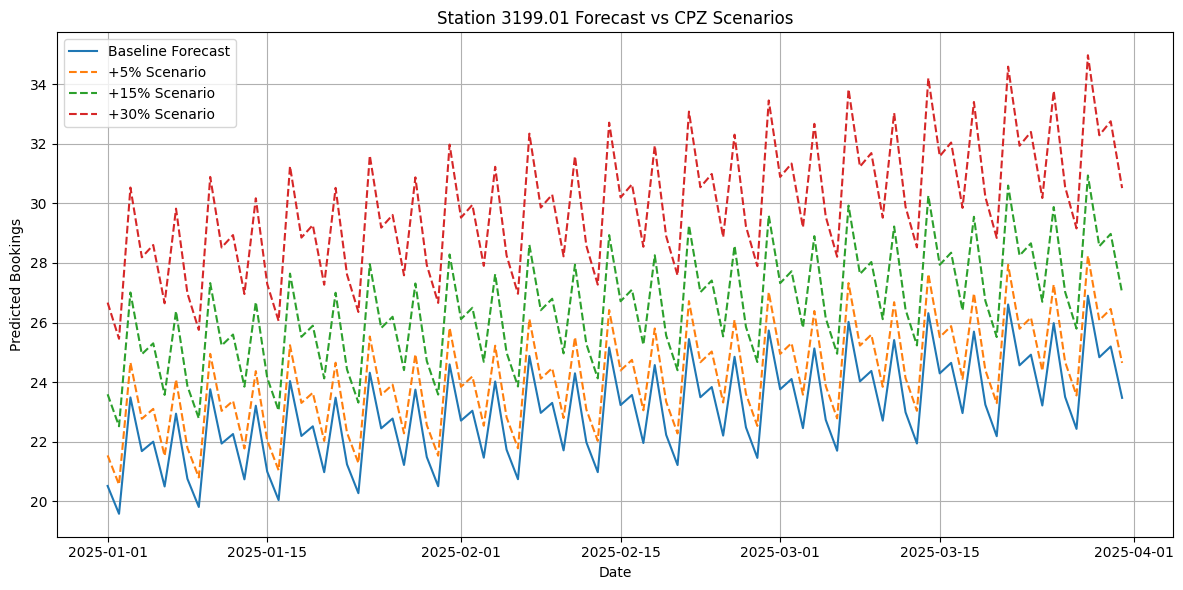

✅ Simulation data saved to: /content/drive/MyDrive/citibike_project/simulated_cpz_impact_2025.csv


In [ ]:
# ✅ CPZ Forecast Simulation & Plotting

import pandas as pd
import matplotlib.pyplot as plt
import glob

# Step 1: Load All Forecast Files
data_path = "/content/drive/MyDrive/citibike_project/forecast_output_2024/*.csv"
forecast_files = glob.glob(data_path)

df_list = [pd.read_csv(f) for f in forecast_files]
df = pd.concat(df_list, ignore_index=True)
df['ds'] = pd.to_datetime(df['ds'])
df['start_station_id'] = df['start_station_id'].astype(str)

# Step 2: Filter Forecast to Post-CPZ Only (2025)
df = df[df['ds'] >= '2025-01-01'].copy()

# Step 3: Simulate CPZ Impact Scenarios
df['sim_low'] = df['yhat'] * 1.05
df['sim_mod'] = df['yhat'] * 1.15
df['sim_high'] = df['yhat'] * 1.30

# Step 4: Plot Forecast vs Simulated Demand for a Sample Station
station_id = '3199.01'  # Change this to any valid station ID
df_station = df[df['start_station_id'] == station_id]

if df_station.empty:
    print(f"⚠️ No forecast data found for station {station_id}")
else:
    plt.figure(figsize=(12, 6))
    plt.plot(df_station['ds'], df_station['yhat'], label='Baseline Forecast')
    plt.plot(df_station['ds'], df_station['sim_low'], label='+5% Scenario', linestyle='--')
    plt.plot(df_station['ds'], df_station['sim_mod'], label='+15% Scenario', linestyle='--')
    plt.plot(df_station['ds'], df_station['sim_high'], label='+30% Scenario', linestyle='--')
    plt.title(f"Station {station_id} Forecast vs CPZ Scenarios")
    plt.xlabel("Date")
    plt.ylabel("Predicted Bookings")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Optional: Save final merged + simulated dataset
output_file = "/content/drive/MyDrive/citibike_project/simulated_cpz_impact_2025.csv"
df.to_csv(output_file, index=False)
print(f"✅ Simulation data saved to: {output_file}")
